# Photogrammetric Flight Planing-Automatization

In [ ]:

import numpy as np
import json
import simplekml
from simplekml import Kml


# 1. GSD, Photo Coverage and Flight Path Functions

In [ ]:

def calculate_gsd(sensor_width, sensor_height, image_width, image_height, focal_length, flight_altitude):
    gsd_x = (sensor_width * flight_altitude) / (focal_length * image_width)
    gsd_y = (sensor_height * flight_altitude) / (focal_length * image_height)
    return gsd_x, gsd_y

def calculate_photo_coverage(image_width, image_height, gsd_x, gsd_y):
    coverage_x = image_width * gsd_x
    coverage_y = image_height * gsd_y
    return coverage_x, coverage_y

def generate_flight_path(area_width, area_height, coverage_x, coverage_y, overlap_x, overlap_y):
    step_x = coverage_x * (1 - overlap_x)
    step_y = coverage_y * (1 - overlap_y)
    num_photos_x = int(np.ceil(area_width / step_x))
    num_photos_y = int(np.ceil(area_height / step_y))
    flight_path = []
    direction = 1
    y = 0
    for i in range(num_photos_y):
        row = []
        for j in range(num_photos_x):
            x = j * step_x if direction == 1 else (num_photos_x - 1 - j) * step_x
            row.append((x, y))
        flight_path.extend(row)
        direction *= -1
        y += step_y
    return flight_path


# 2. GCP Positions Functions (Not fixed!)

In [ ]:

def calculate_ykn_positions(area_width, area_height, grid_spacing=300):
    ykn_positions = []
    grid_x = max(3, int(area_width / grid_spacing) + 1)
    grid_y = max(3, int(area_height / grid_spacing) + 1)
    cell_width = area_width / (grid_x - 1)
    cell_height = area_height / (grid_y - 1)
    for i in range(grid_x):
        for j in range(grid_y):
            x = i * cell_width
            y = j * cell_height
            if (i == 0 and j == 0) or (i == grid_x-1 and j == 0) or                (i == 0 and j == grid_y-1) or (i == grid_x-1 and j == grid_y-1):
                ykn_positions.append((x, y))
                if i == 0 and j == 0:
                    ykn_positions.append((x + cell_width/3, y + cell_height/3))
                elif i == grid_x-1 and j == 0:
                    ykn_positions.append((x - cell_width/3, y + cell_height/3))
                elif i == 0 and j == grid_y-1:
                    ykn_positions.append((x + cell_width/3, y - cell_height/3))
                elif i == grid_x-1 and j == grid_y-1:
                    ykn_positions.append((x - cell_width/3, y - cell_height/3))
            elif i == 0 or i == grid_x-1 or j == 0 or j == grid_y-1:
                if (i % 2 == 0 and (j == 0 or j == grid_y-1)) or                    (j % 2 == 0 and (i == 0 or i == grid_x-1)):
                    ykn_positions.append((x, y))
            else:
                if i % 3 == 1 and j % 3 == 1:
                    ykn_positions.append((x, y))
    total_ykn = len(ykn_positions)
    min_check_points = max(4, int(total_ykn * 0.3))
    if total_ykn < 12:
        for i in range(1, grid_x-1):
            for j in range(1, grid_y-1):
                if i % 2 == 1 and j % 2 == 1 and (i, j) not in ykn_positions:
                    x = i * cell_width
                    y = j * cell_height
                    ykn_positions.append((x, y))
    return len(ykn_positions), ykn_positions


# 3. Understanding the Field on the given KML File, Saving the Flight Plan in accordance with this Field and GSD Control Functions

In [ ]:

import xml.etree.ElementTree as ET
import os

def read_area_from_kml(input_kml_path):
    namespaces = {'kml': 'http://www.opengis.net/kml/2.2', 'atom': 'http://www.w3.org/2005/Atom'}
    tree = ET.parse(input_kml_path)
    root = tree.getroot()
    coordinates_elem = root.find('.//kml:coordinates', namespaces)
    if coordinates_elem is None:
        raise ValueError("Cant find coordinates in kml file")
    coords_text = coordinates_elem.text.strip()
    coord_pairs = coords_text.split()
    coords = []
    for pair in coord_pairs:
        parts = pair.split(',')
        if len(parts) >= 2:
            lon, lat = float(parts[0]), float(parts[1])
            coords.append((lon, lat))
    lons = [c[0] for c in coords]
    lats = [c[1] for c in coords]
    return min(lons), min(lats), max(lons), max(lats)

def save_kml(flight_path, ykn_positions, min_lon, min_lat, max_lon, max_lat, filename="flight_plan.kml", flight_altitude=364.5):
    kml = Kml()
    area_poly = kml.newpolygon(name="Study Area")
    area_poly.outerboundaryis = [(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat), (min_lon, min_lat)]
    area_poly.style.linestyle.color = 'ffff0000'
    area_poly.style.linestyle.width = 2
    area_poly.style.polystyle.color = '7fff0000'
    real_flight_path = []
    for x, y in flight_path:
        lon = min_lon + (x / (111320 * np.cos(np.radians(min_lat))))
        lat = min_lat + (y / 111320)
        real_flight_path.append((lon, lat, flight_altitude))
    linestring = kml.newlinestring(name="Flight Path")
    linestring.coords = real_flight_path
    linestring.altitudemode = simplekml.AltitudeMode.absolute
    linestring.style.linestyle.color = "ff0000ff"
    linestring.style.linestyle.width = 2
    for idx, (lon, lat, alt) in enumerate(real_flight_path):
        pnt = kml.newpoint(name=f"Foto-{idx+1}", coords=[(lon, lat, alt)])
        pnt.altitudemode = simplekml.AltitudeMode.absolute
        pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/camera.png'
        pnt.style.iconstyle.color = "ffffffff"
        pnt.style.iconstyle.scale = 0.5
    for idx, (x, y) in enumerate(ykn_positions):
        lon = min_lon + (x / (111320 * np.cos(np.radians(min_lat))))
        lat = min_lat + (y / 111320)
        pnt = kml.newpoint(name=f"YKN-{idx+1}", coords=[(lon, lat, 0)])
        pnt.altitudemode = simplekml.AltitudeMode.absolute
        pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
        pnt.style.iconstyle.color = "ff00ff00"
        pnt.style.iconstyle.scale = 1.0
    save_path = os.path.join(r"C:\Users\Root\Desktop\8. Semi Semester\Photogrammetric Project", filename)
    kml.save(save_path)
    print(f"KML file saved: {save_path}")

def check_gsd_for_map_scale(gsd, map_scale=1000):
    max_gsd = 0.1
    if gsd > max_gsd:
        return False, f"WARNING: The GSD value cannot be greater than 10 cm for a 1/{map_scale} scale map. Current GSD: {gsd*100:.2f} cm"
    return True, f"The GSD value is suitable for a 1/{map_scale} scale map. Current GSD: {gsd*100:.2f} cm"


# 4. Final Determination of Flight Characteristics According to Desired Parameters

# DJI Phantom 4 Pro Camera Properties (The camera used in this example)
https://www.dxomark.com/Cameras/DJI/Phantom4-Pro---Specifications

In [17]:
def get_parameter(prompt, default, type_func):
    """
    Helper function to get parameters from the user.
    Returns the default value if left empty.
    """
    user_input = input(f"{prompt} (Default: {default}): ")
    if user_input.strip() == "":
        return default
    try:
        return type_func(user_input)
    except Exception as e:
        print(f"Error: {e}. Default variable ({default}) using.")
        return default

# Get parameters from user 
desired_gsd_cm = get_parameter("Please enter the desired GSD value (cm)", 10.0, float)
sensor_width   = get_parameter("Camera sensor width (mm)", 13.2, float)
sensor_height  = get_parameter("Camera sensor height (mm)", 8.8, float)
image_width    = get_parameter("Image width (px)", 5472, int)
image_height   = get_parameter("Image height (px)", 3648, int)
focal_length   = get_parameter("Focal length (mm)", 8.8, float)
overlap_x      = get_parameter("Overlap ratio - longitudinal (0-1)", 0.7, float)
overlap_y      = get_parameter("Overlap ratio - lateral (0-1)", 0.3, float)
min_lon        = get_parameter("Study area minimum longitude (lon)", 26.830821, float)
min_lat        = get_parameter("Study area minimum latitude (lat)", 38.732225, float)
max_lon        = get_parameter("Study area maximum longitude (lon)", 26.842528, float)
max_lat        = get_parameter("Study area maximum latitude (lat)", 38.741552, float)

# Convert the desired GSD (cm) value to meters and calculate the required flight altitude
desired_gsd = desired_gsd_cm / 100.0
flight_altitude = (desired_gsd * focal_length * image_width) / sensor_width

# Using previously defined functions for calculations:
# calculate_gsd, calculate_photo_coverage, generate_flight_path, calculate_ykn_positions, check_gsd_for_map_scale, save_kml

gsd_x, gsd_y = calculate_gsd(sensor_width, sensor_height, image_width, image_height, focal_length, flight_altitude)
is_valid, message = check_gsd_for_map_scale(gsd_x)
print(message)
if not is_valid:
    max_gsd = 0.1  # 10 cm
    recommended_altitude = (max_gsd * focal_length * image_width) / sensor_width
    print(f"Recommended maximum flight altitude: {recommended_altitude:.2f} meters")

# Calculate study area dimensions (in meters)
import numpy as np
area_width  = (max_lon - min_lon) * 111320 * np.cos(np.radians(min_lat))
area_height = (max_lat - min_lat) * 111320
print(f"Study area coordinates: {min_lon:.6f}, {min_lat:.6f} - {max_lon:.6f}, {max_lat:.6f}")
print(f"Study area dimensions: {area_width:.2f} m x {area_height:.2f} m")

# Calculate the area covered by the photo on the ground
coverage_x, coverage_y = calculate_photo_coverage(image_width, image_height, gsd_x, gsd_y)

# Create flight path (grid-based)
flight_path = generate_flight_path(area_width, area_height, coverage_x, coverage_y, overlap_x, overlap_y)

# Calculate GCP positions
total_ykn, ykn_positions = calculate_ykn_positions(area_width, area_height)

# Save KML file (study area and flight path with real coordinates)
save_kml(flight_path, ykn_positions, min_lon, min_lat, max_lon, max_lat, "flight_plan_yenifoca_test1")

# Convert flight path and GCP points to real coordinates
real_flight_path = []
for x, y in flight_path:
    lon = min_lon + (x / (111320 * np.cos(np.radians(min_lat))))
    lat = min_lat + (y / 111320)
    real_flight_path.append((lon, lat, flight_altitude))

real_ykn_positions = []
for x, y in ykn_positions:
    lon = min_lon + (x / (111320 * np.cos(np.radians(min_lat))))
    lat = min_lat + (y / 111320)
    real_ykn_positions.append((lon, lat))

# Print results
print("\n--- Calculation Results ---")
print(f"Desired GSD: {desired_gsd_cm:.2f} cm")
print(f"Calculated GSD: {gsd_x*100:.2f} cm/pixel")
print(f"Required flight altitude: {flight_altitude:.2f} meters (from sea level)")
print(f"Area covered by photo: {coverage_x:.2f} m x {coverage_y:.2f} m")
print(f"Study area dimensions: {area_width:.2f} m x {area_height:.2f} m")
print(f"Total number of photos: {len(flight_path)}")
print(f"Total number of GCPs: {total_ykn}")

print("\nFlight path (first 5 points):")
for pt in real_flight_path[:5]:
    print(f"  {pt}")

print("\nGCP positions (first 5 points):")
for pt in real_ykn_positions[:5]:
    print(f"  {pt}")



Please enter the desired GSD value (cm) (Default: 10.0): 10.0
Camera sensor width (mm) (Default: 13.2): 
Camera sensor height (mm) (Default: 8.8): 
Image width (px) (Default: 5472): 
Image height (px) (Default: 3648): 
Focal length (mm) (Default: 8.8): 
Overlap ratio - longitudinal (0-1) (Default: 0.7): 
Overlap ratio - lateral (0-1) (Default: 0.3): 
Study area minimum longitude (lon) (Default: 26.830821): 
Study area minimum latitude (lat) (Default: 38.732225): 
Study area maximum longitude (lon) (Default: 26.842528): 
Study area maximum latitude (lat) (Default: 38.741552): 
The GSD value is suitable for a 1/1000 scale map. Current GSD: 10.00 cm
Study area coordinates: 26.830821, 38.732225 - 26.842528, 38.741552
Study area dimensions: 1016.62 m x 1038.28 m
KML file saved: C:\Users\Root\Desktop\8. Semi Semester\Photogrammetric Project\flight_plan_yenifoca_test1
Flight altitude: 364.5 meters (above sea level)

--- Calculation Results ---
Desired GSD: 10.00 cm
Calculated GSD: 10.00 cm/pi

# 5. Visualizing The Flight Plan and GCPs

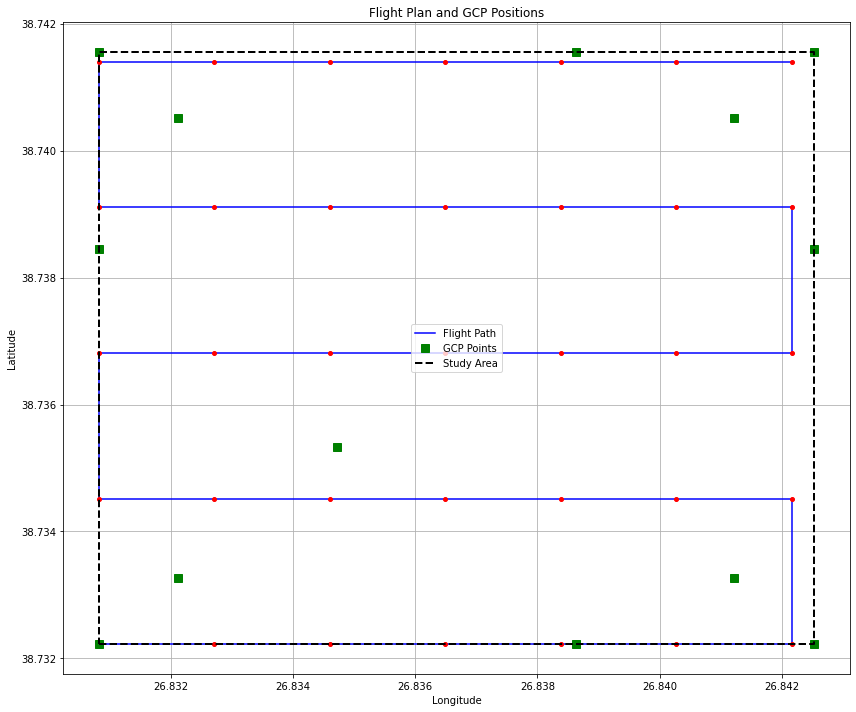

In [18]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(12, 10))

# Plot flight path
flight_lons = [point[0] for point in real_flight_path]
flight_lats = [point[1] for point in real_flight_path]
plt.plot(flight_lons, flight_lats, 'b-', linewidth=1.5, label='Flight Path')
plt.plot(flight_lons, flight_lats, 'ro', markersize=4)

# Plot GCP positions
ykn_lons = [point[0] for point in real_ykn_positions]
ykn_lats = [point[1] for point in real_ykn_positions]
plt.plot(ykn_lons, ykn_lats, 'gs', markersize=8, label='GCP Points')

# Plot study area boundaries
area_lons = [min_lon, max_lon, max_lon, min_lon, min_lon]
area_lats = [min_lat, min_lat, max_lat, max_lat, min_lat]
plt.plot(area_lons, area_lats, 'k--', linewidth=2, label='Study Area')

# Graph settings
plt.title('Flight Plan and GCP Positions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the graph
plt.show()